In [11]:
import torch

import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision
import matplotlib.pyplot as plt

from network import *
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
bs=100
# MNIST Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [13]:
 #build network
z_dim = 100
G = Generator().to(device)
D = BDiscriminator().to(device)

In [14]:
D(torch.rand(2,1,28,28,device=device)).shape

torch.Size([2, 1, 28, 28])

In [15]:
gamma = 0.75
lambda_k = 0.001
k = 0.0

In [16]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.00005 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [17]:
def calc_gradient_penalty(netD, real_data, fake_data, LAMBDA,device='cpu'):
    alpha = torch.rand(1, 1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.to(device)
    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = interpolates.to(device)#.cuda()
    interpolates = torch.autograd.Variable(interpolates, requires_grad=True)
    disc_interpolates = netD(interpolates)
    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),#.cuda(), #if use_cuda else torch.ones(
                                  #disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

In [18]:
def D_train(x):
    D.zero_grad()
    bs = x.shape[0]
    
    # train discriminator on real
    x_real, y_real = x, torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    d_real  = D(x_real)

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim,1,1).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    d_fake  = D(x_fake.detach())

    
    d_loss_real = torch.mean(torch.abs(d_real - x_real))
    d_loss_fake = torch.mean(torch.abs(d_fake - x_fake.detach()))
    d_loss = d_loss_real - k * d_loss_fake
    



    d_loss.backward()
    D_optimizer.step()
        
    return  d_loss.item(),d_loss_real.detach(),d_loss_fake.detach()

In [19]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()
    bs = x.shape[0]
    z = Variable(torch.randn(bs, z_dim,1,1).to(device))
    G_output = G(z)
    g_loss = torch.mean(torch.abs(D(G_output) - G_output))

    g_loss.backward()
    G_optimizer.step()
        
    return g_loss.item(),G_output.detach()


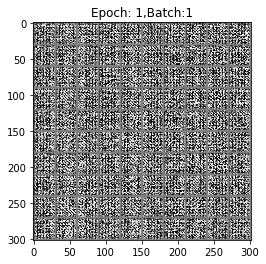

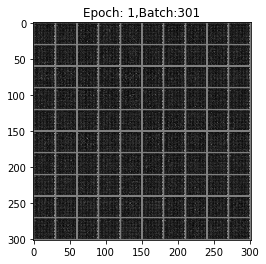

[1/20]: loss_d: 0.432, loss_g: 0.303


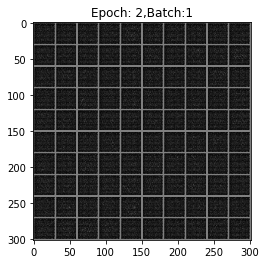

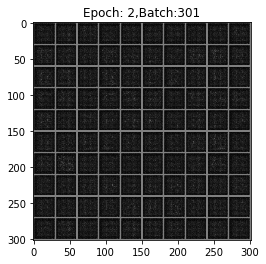

[2/20]: loss_d: 0.350, loss_g: 0.262


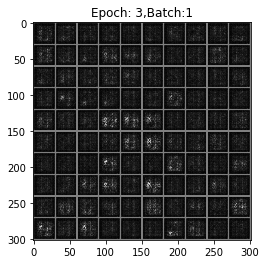

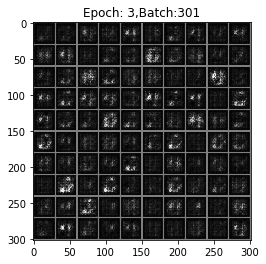

[3/20]: loss_d: 0.306, loss_g: 0.239


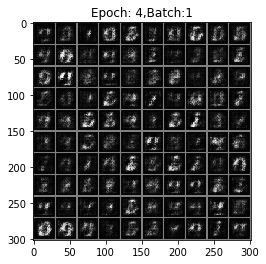

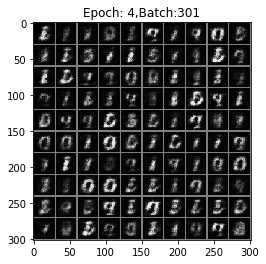

[4/20]: loss_d: 0.278, loss_g: 0.214


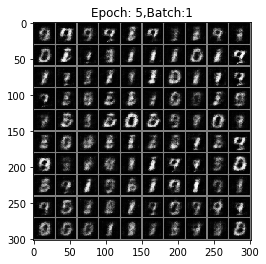

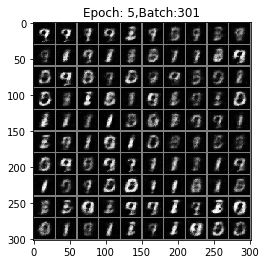

[5/20]: loss_d: 0.259, loss_g: 0.194


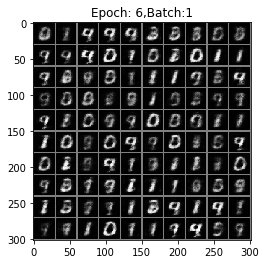

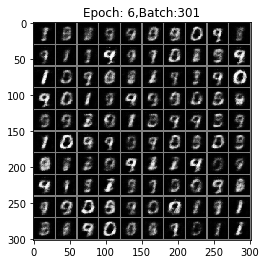

[6/20]: loss_d: 0.245, loss_g: 0.181


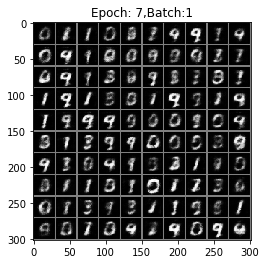

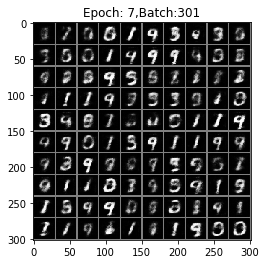

[7/20]: loss_d: 0.234, loss_g: 0.172


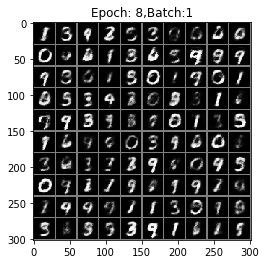

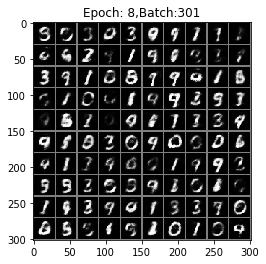

[8/20]: loss_d: 0.225, loss_g: 0.166


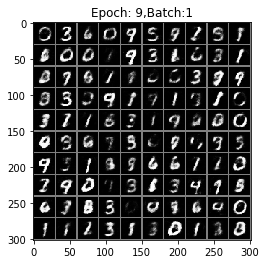

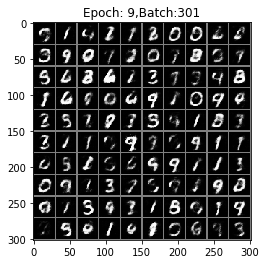

[9/20]: loss_d: 0.217, loss_g: 0.161


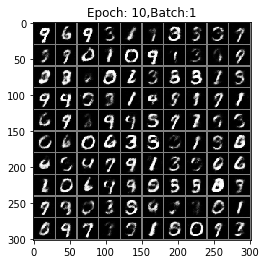

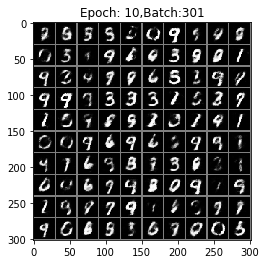

[10/20]: loss_d: 0.211, loss_g: 0.157


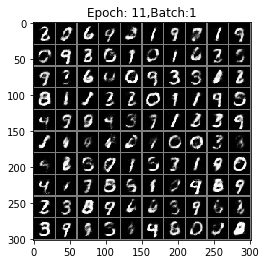

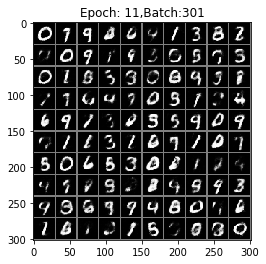

[11/20]: loss_d: 0.206, loss_g: 0.153


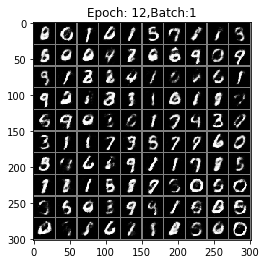

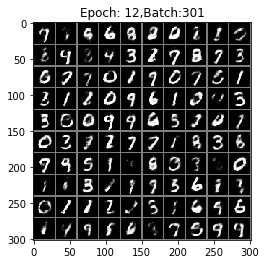

[12/20]: loss_d: 0.201, loss_g: 0.149


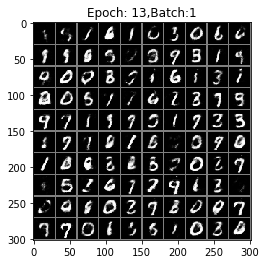

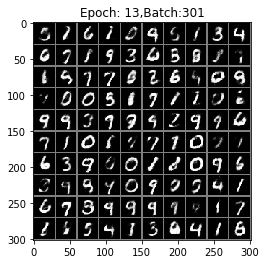

[13/20]: loss_d: 0.197, loss_g: 0.147


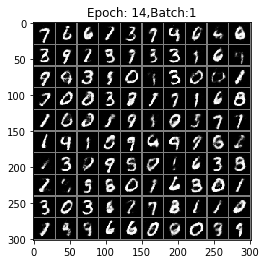

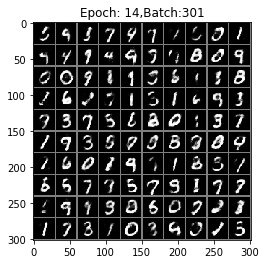

[14/20]: loss_d: 0.193, loss_g: 0.144


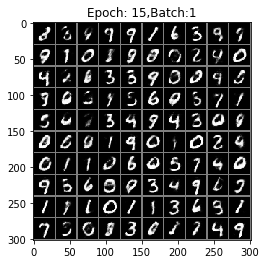

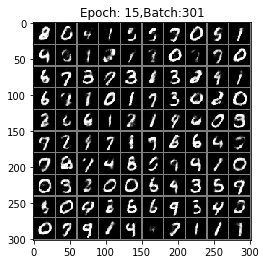

[15/20]: loss_d: 0.190, loss_g: 0.141


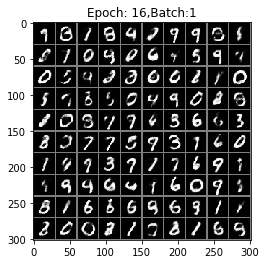

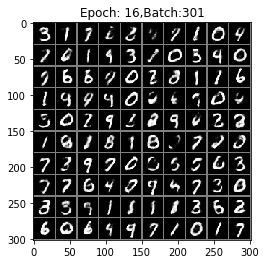

[16/20]: loss_d: 0.187, loss_g: 0.139


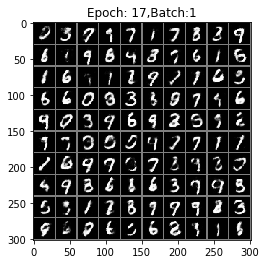

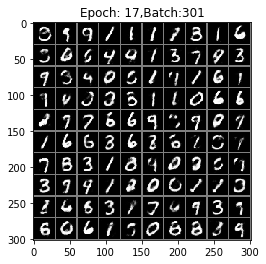

[17/20]: loss_d: 0.184, loss_g: 0.137


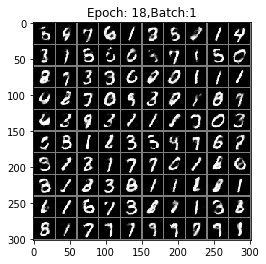

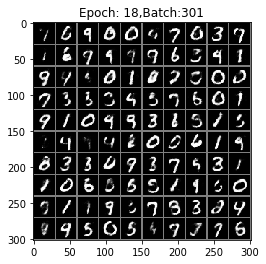

[18/20]: loss_d: 0.181, loss_g: 0.135


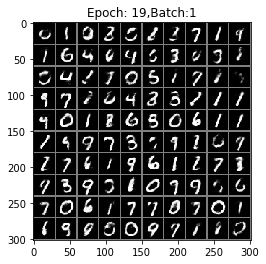

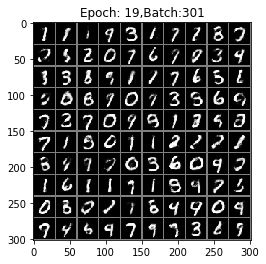

[19/20]: loss_d: 0.179, loss_g: 0.134


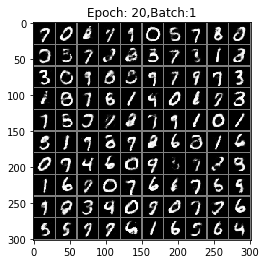

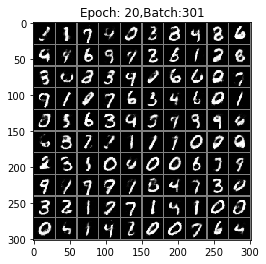

[20/20]: loss_d: 0.177, loss_g: 0.132


In [20]:
n_epoch = 20
Ms=[]
D_losses, G_losses = [], []
for epoch in range(1, n_epoch+1):           
    for batch_idx, (x, _) in enumerate(train_loader):

        D_loss,d_re,d_fa=D_train(x)
        D_losses.append(D_loss)
        G_loss,gen_data=G_train(x)

        diff=gamma*d_re-d_fa
        k=k+lambda_k*diff
        k=min(max(k,0),1)
        
        M=(d_re+abs(diff))
        Ms.append(M)
        G_losses.append(G_loss)
        if batch_idx %300 ==0:
            gen_data=gen_data.view(100,1,28,28)
            grid_img = torchvision.utils.make_grid(gen_data, nrow=10)
            plt.figure()
            plt.title(f"Epoch: {epoch},Batch:{batch_idx+1}")
            plt.imshow(grid_img.cpu().permute(1,2,0)*0.5+0.5)
            plt.show()

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

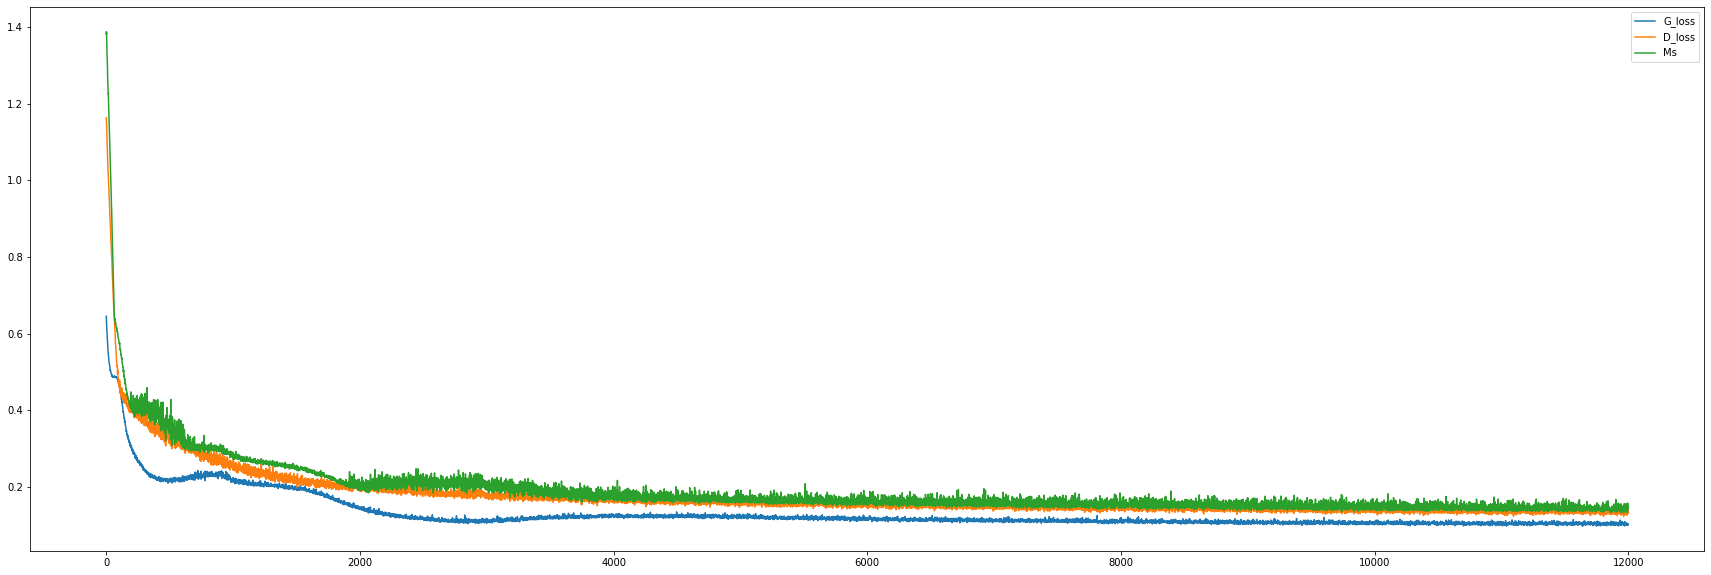

In [23]:
plt.figure(figsize=(30,10))
plt.plot(G_losses,label='G_loss')
plt.plot(D_losses,label='D_loss')
plt.plot(Ms,label='Ms')

plt.legend()

#plt.legend("D_losses")


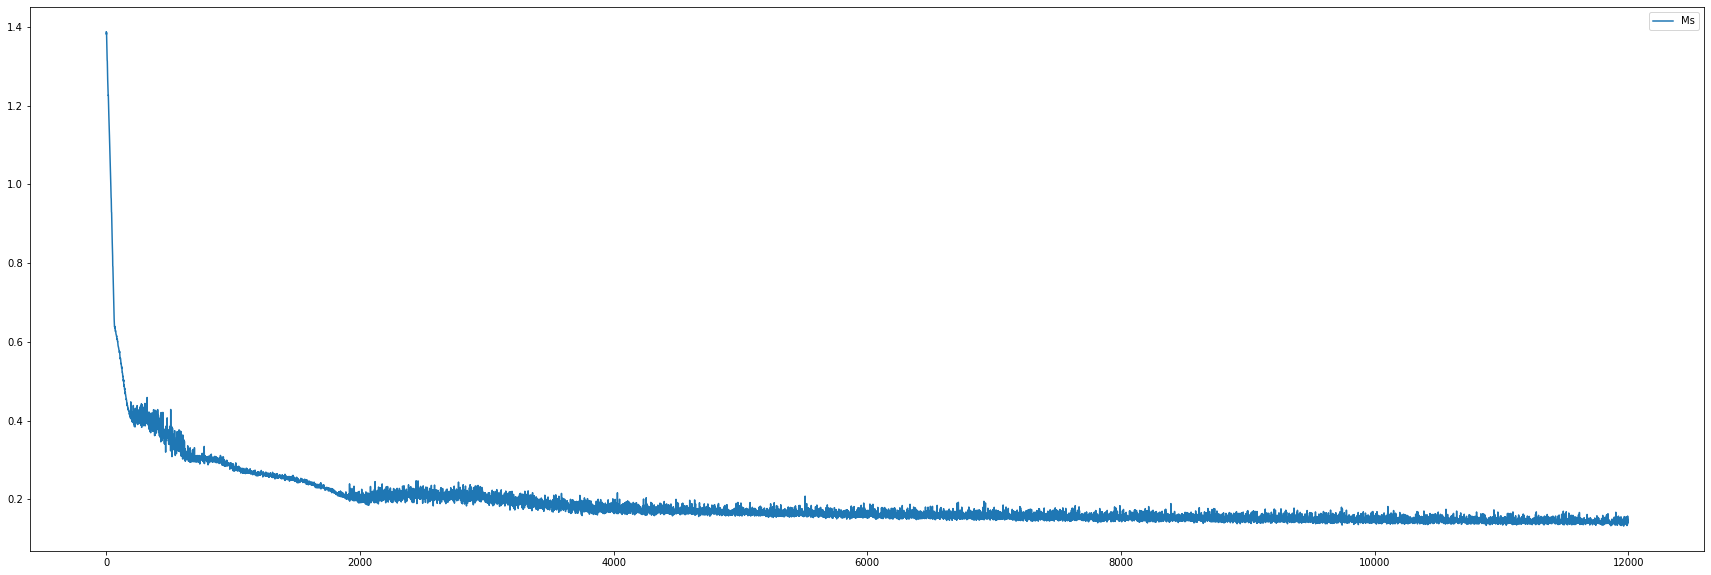

In [24]:
plt.figure(figsize=(30,10))
plt.plot(Ms,label='Ms')
plt.legend()

#plt.legend("D_losses")
